In [2]:
import sys 
import pandas as pd
import numpy as np
import itertools
import math
import warnings
import threading
import matplotlib.pyplot as plt
import time
from pprint import pprint
import multiprocessing as mp
from multiprocessing import Queue

In [3]:

'''Get inputs as group1, group2, Donor-Acceptor distance,angle cutoff from the user '''
   
natoms=int(input('Enter the number of atoms: '))

group1=[]
nums=[num for num in input("Enter list of atoms like 2,5,6-10, For all press Enter: ").strip().split(',')]
for i in nums:
     if i=='':
         break
     if "-" in i:
         m=i.split('-')
         for j in range(int(m[0]), int(m[1])+1,1):
             group1.append(int(j))        
     else:
         group1.append(int(i))
group1=sorted(group1)

 
group2=[]
nums=[num for num in input("Enter list of atoms like 2,5,6-10, For all press Enter: ").strip().split(',')]
for i in nums:
     if i=='':
         break
     if "-" in i:
         m=i.split('-')
         for j in range(int(m[0]), int(m[1])+1,1):
             group2.append(int(j))        
     else:
         group2.append(int(i))
group2=sorted(group2)

      
cutoff_distance=float(input('Enter the Donor-Acceptor distance in Angstrom like 3.5: '))
cutoff_angle=float(input('Enter the angle cutoff in degree like 30: '))


Enter the number of atoms: 12670
Enter list of atoms like 2,5,6-10, For all press Enter: 
Enter list of atoms like 2,5,6-10, For all press Enter: 
Enter the Donor-Acceptor distance in Angstrom like 3.5: 3.5
Enter the angle cutoff in degree like 30: 30


In [4]:
def pdb2xyz(filename,frame=None,group1=None,group2=None):
         ''' read the file, skips first two lines and create atom_list, and atom_info list'''
         with open (filename) as tf:
            for line in itertools.islice(tf,frame*(natoms+7),(frame+1)*(natoms+5)):
                tl=pd.read_csv(tf,sep='\s+', header=None, nrows=natoms,skiprows=4)
                if group1 and group2:
                    selection1=[(tl[2][s],tl[5][s],tl[6][s],tl[7][s]) for s in group1]
                    selection2=[(tl[2][s],tl[5][s],tl[6][s],tl[7][s]) for s in group2]
                else:
                    selection1=list(zip(tl[2],tl[5],tl[6],tl[7]))
                    selection2=list(zip(tl[2],tl[5],tl[6],tl[7]))
                tot=list(zip(tl[2],tl[5],tl[6],tl[7]))              
                return(selection1,selection2,tot)

In [5]:
def atom_groups(selection1,selection2):
        h_list=[]
        donor_list=[]
        acceptor_list=[]
        select=['O','N','F','Zn','C']       

        '''Find D-H (Donor and hydrogen) groups''' #bond={'NH': 0.99,'OH': 0.98} 
        for i  in range(len(selection1)):
            if 'H' in selection1[i][0]:
                h_list.append(i)
        
                
        for i  in range(len(selection1)):
            for s in select:
                if s in selection1[i][0]:
                    for j in h_list:
                        if round(math.dist((selection1[i][1],selection1[i][2],selection1[i][3]),
                                           (selection1[j][1],selection1[j][2],selection1[j][3])),1)<=1.0:
                            donor_list.append((i,j)) 
                    
        '''Find Acceptor groups''' 
        for i  in range(len(selection2)):
            for j in select:
                if j in selection2[i][0]:
                    acceptor_list.append(i)
        return(donor_list,acceptor_list) 

In [6]:
def angle(i,j,k):
    '''calcualte angle between i,j,k
    >>> angle((1,0,0),(0,0,0),(-1,0,0))  
    180.0    
    '''
    a = np.array(i)
    b = np.array(j)
    c = np.array(k)
    f=b-a
    e=b-c
    cosine_angle = np.dot(f, e) / (np.linalg.norm(f) * np.linalg.norm(e))
    warnings.simplefilter("ignore")
    angle = np.degrees(np.arccos(cosine_angle))
    return(angle)
#import doctest
#doctest.testmod()

In [8]:
def hbond(traj_input,frame,group1,group2):
         data=pdb2xyz(traj_input,frame,group1,group2)
         selection1=data[0]
         selection2=data[1]
         tot=data[2]
         data2=atom_groups(selection1,selection2)
         donor_list=data2[0]
        # print(donor_list)
         acceptor_list=data2[1]
        # print(acceptor_list)
         hbond=0  
         for (d,h) in donor_list:
             for a in acceptor_list:
                 distance=math.dist((selection2[a][1],selection2[a][2],selection2[a][3]),(selection1[d][1],selection1[d][2],selection1[d][3]))
                 angles=angle((selection2[a][1],selection2[a][2],selection2[a][3]),(selection1[d][1],selection1[d][2],selection1[d][3]),(selection1[h][1],selection1[h][2],selection1[h][3]))      
                 if round(distance,2)<= cutoff_distance:    
                       if round(angles,2)<=cutoff_angle:
                      #      print((tot.index(selection2[a]),tot.index(selection1[d]),tot.index(selection1[h])), distance, angles)
                            hbond +=1
         return((frame,hbond))

In [9]:
hbond_n=[]
processes = []
que = mp.Queue()
def multiprocess(traj=None,b=None,e=None):
    traj_input=traj
    b=int(b)
    e=int(e)
    for i in range (b,e):
        frame=i
        p = mp.Process(target=lambda q, arg1: q.put(hbond(traj_input,frame,group1,group2)),
                             args=(que, frame))
        processes.append(p)
        p.start()
    for p in processes:
        p.join() 
        
    while not que.empty():
        hbond_n.append (que.get())

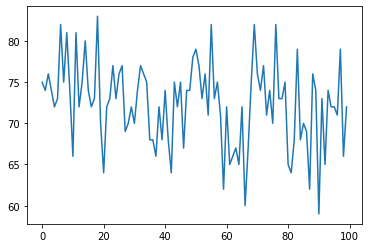

CPU times: user 206 ms, sys: 137 ms, total: 343 ms
Wall time: 21min 30s


In [9]:
%%time    
multiprocess(r"GOX/trjconv-gromacs.pdb",0,100)
hbond_n.sort()
x_val=[x[0] for x in hbond_n]
y_val=[x[1] for x in hbond_n]
fig=plt.plot(x_val,y_val)
plt.show()

In [10]:
with open("myfile.csv", "w") as out_file:
    for i in range(len(x_val)):
        out_file.write("%i %5.2f\n" % (x_val[i],  y_val[i]))    

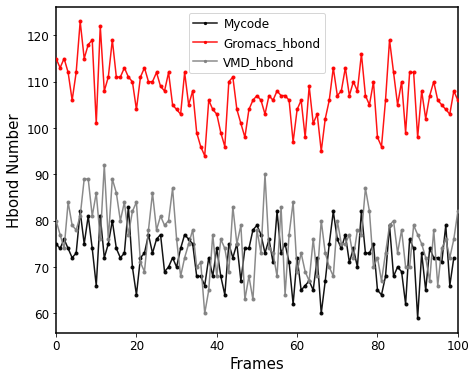

In [12]:
import pylab
from pylab import *
fig = plt.figure(figsize=(1.2*6,6)) 


data1 = np.genfromtxt((r for r in open('GOX/hbon-sol-surface-gromacs.xvg') if not r[0] in ('@', '#', '&')))
frame1 = data1.T[0]  # time in ps
hbond1 = data1.T[1]

data2 = np.genfromtxt((r for r in open('GOX/hbond-sol-surface-vmd.dat') if not r[0] in ('@', '#', '&')))
frame2 = data2.T[0]  # time in ps
hbond2 = data2.T[1]

# make a plot of Potential energy vs simulation steps
plt.plot(x_val,y_val, marker='.', color='black', linestyle='-', lw=1.5, zorder = 500,
         markeredgewidth=1, alpha=0.92, label='Mycode')
plt.plot(frame1,hbond1, marker='.', color='red', linestyle='-', lw=1.5, zorder = 500,
         markeredgewidth=1, alpha=0.92, label='Gromacs_hbond')
plt.plot(frame2,hbond2, marker='.', color='gray', linestyle='-', lw=1.5, zorder = 500,
         markeredgewidth=1, alpha=0.92, label='VMD_hbond')


xlabel('Frames', size=15)
ylabel('Hbond Number', size=15)
pylab.yticks(fontsize=12)
pylab.xticks(fontsize=12)


plt.legend(loc='best', ncol=1, columnspacing=2, handletextpad=0.5,
           fancybox=True, numpoints=1, markerscale=0.75, fontsize=12).set_alpha(0.5)


pylab.xlim([0,100])


ax = fig.add_subplot(111)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

pylab.savefig('hbond-SOL-surface-GOX.png', format='png', bbox_inches='tight')
plt.show()